In [270]:
import pandas as pd
import torch
import tldextract
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import re
import numpy as np
from gensim.models import FastText
from sklearn.metrics import precision_recall_curve, f1_score,roc_auc_score,confusion_matrix
from gensim.models import FastText
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import string
import random
import warnings
import optuna
warnings.filterwarnings('ignore')
random.seed(123)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lanmo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [271]:
stop_words_en = set(stopwords.words("english"))
stop_words_ru = set(stopwords.words("russian"))
stop_words = stop_words_en | stop_words_ru

In [272]:
train = pd.read_csv(r'train_data.csv',index_col = 0)
test = pd.read_csv(r'test_data.csv',index_col = 0)

In [273]:
train.isna().sum()

url      0
title    1
label    0
dtype: int64

In [274]:
test.isna().sum()

url      0
title    0
dtype: int64

In [275]:
train[train['title'].isna()]

,url,title,label
ID,,,
78497,jpg-1.com,NaN,0


In [276]:
train.dropna(inplace = True)

# Чекним дизбаланс классов

In [277]:
train['label'].value_counts()/train.shape[0] * 100

label
0    87.646702
1    12.353298
Name: count, dtype: float64

Есть большой дизбаланс классов и с этим нужно будет что-то делать

# Обработаем данные
## Буду отдельно обрабатывать url и title

In [278]:
def get_clean_url(text):
    domain = tldextract.extract(text).domain
    if domain == '':
        domain = 'domains'
    return domain

In [279]:
def remove_punctuation(text):
    translation_table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    cleaned_text = text.translate(translation_table)
    return cleaned_text

In [280]:
def clean_data(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = re.sub(r"\d+", " ",text)
    spec = []
    for tex in text.split():
        if tex not in stop_words and tex not in string.punctuation + '—':
            spec.append(tex)
    return ' '.join(spec)

In [281]:
def sentence_to_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [282]:
def sentence_to_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [283]:
def get_best_tresh(y_test,y_prob):
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best Threshold: {best_threshold}")
    print(f"Best F1-Score: {np.max(f1_scores)}")
    return best_threshold

In [284]:
#Объединяем
full = pd.concat([train,test],axis = 0)

In [285]:
full['url_clean'] = full['url'].apply(lambda x: remove_punctuation(get_clean_url(x))) #Очищаем url
full['clean_title'] = full['title'].apply(clean_data) # Очищаем текст
full.drop(['url','title'],axis = 1,inplace = True) #Удаляем оригиналы

In [286]:
#Преобразовываем в вектор
sentenses_url = full['url_clean'].apply(lambda x: x.split()).to_list() 
sentenses_title = full['clean_title'].apply(lambda x: x.split()).to_list() 

In [314]:
#Обучаем fasttext
model1 = FastText(sentenses_url,vector_size=250, window=1, min_count=1, epochs=20)
model2 = FastText(sentenses_title,vector_size=250, window=3, min_count=1, epochs=20)

In [315]:
full.loc[:, 'vector_url'] = full['url_clean'].apply(lambda x: sentence_to_vector(x, model1))

In [316]:
full.loc[:, 'vector_tittle'] = full['clean_title'].apply(lambda x: sentence_to_vector(x, model2))

In [317]:
model1.wv.most_similar('porn',topn=10)

[('porndoporn', 0.9977558255195618),
 ('bdsmporn', 0.9975000023841858),
 ('porncorn', 0.9973911046981812),
 ('upporn', 0.9973168969154358),
 ('myporn', 0.9971817135810852),
 ('nfporn', 0.9969819188117981),
 ('porndorn', 0.9969692230224609),
 ('mdhporn', 0.9969276785850525),
 ('k2porn', 0.9969239830970764),
 ('fhdporn', 0.9968552589416504)]

In [318]:
model2.wv.most_similar('sex',topn=10)

[('sexmex', 0.9569888114929199),
 ('nxsex', 0.9487061500549316),
 ('スポコス汗だくsex', 0.9460588693618774),
 ('ガクブル露出sex', 0.9449674487113953),
 ('cxcxsex', 0.9448282718658447),
 ('ryhmдsex', 0.9388653635978699),
 ('bysex', 0.9385769963264465),
 ('yupsex', 0.9362478256225586),
 ('twixsex', 0.9273706078529358),
 ('セクシー美人の腰フリ主観sex', 0.9257761836051941)]

In [319]:
full.isna().sum()

label            161270
url_clean             0
clean_title           0
vector_url            0
vector_tittle         0
dtype: int64

In [320]:
train = full.dropna()
test = full[full['label'].isna()].drop('label',axis = 1)

# Для url

In [321]:
X = train.drop(['label'],axis = 1)
y = train['label']
print(len(X),len(y))

135308 135308


In [322]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2,shuffle=True)

In [323]:
X_train_url= np.vstack(X_train['vector_url'].values)
X_test_url = np.vstack(X_test['vector_url'].values)

In [324]:
cat1 = CatBoostClassifier(
    iterations=400,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',  # Указываем метрику ROC-AUC
    verbose=50  # Уровень детализации вывода
)

In [325]:
cat1.fit(
    X_train_url, y_train,
    eval_set=(X_test_url, y_test),
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8345353	best: 0.8345353 (0)	total: 173ms	remaining: 1m 8s
50:	test: 0.9390158	best: 0.9390158 (50)	total: 6.13s	remaining: 41.9s
100:	test: 0.9553399	best: 0.9553399 (100)	total: 11.4s	remaining: 33.9s
150:	test: 0.9635581	best: 0.9635581 (150)	total: 16.9s	remaining: 27.9s
200:	test: 0.9673248	best: 0.9673248 (200)	total: 22s	remaining: 21.7s
250:	test: 0.9705588	best: 0.9705588 (250)	total: 27s	remaining: 16s
300:	test: 0.9729333	best: 0.9729333 (300)	total: 32.1s	remaining: 10.6s
350:	test: 0.9746141	best: 0.9746141 (350)	total: 37.6s	remaining: 5.25s
399:	test: 0.9757394	best: 0.9757394 (399)	total: 42.7s	remaining: 0us

bestTest = 0.97573945
bestIteration = 399



In [326]:
y_pred_proba = cat1.predict_proba(X_test_url)[:,1]
y_pred = cat1.predict(X_test_url)

In [327]:
print(f'f1: {f1_score(y_test,y_pred)}')
print(f'roc_auc = {roc_auc_score(y_test,y_pred_proba)}')

f1: 0.8910569105691059
roc_auc = 0.9757394499919204


In [328]:
best_threshold = get_best_tresh(y_test,y_pred_proba)

Best Threshold: 0.2732880597111533
Best F1-Score: 0.9008560311284046


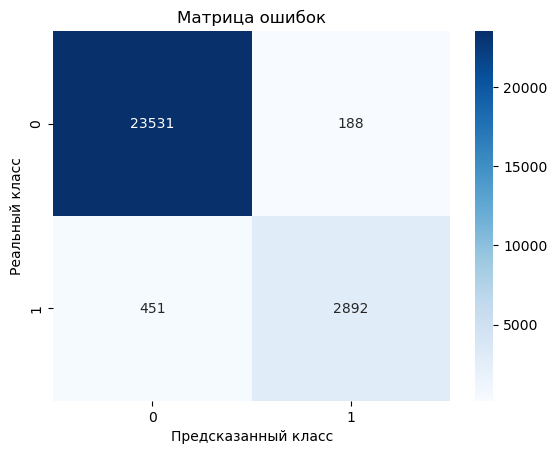

In [329]:
y_pred = (y_pred_proba > best_threshold).astype(int)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Реальный класс')
plt.title('Матрица ошибок')
plt.show()

# Для title

In [330]:
X_train_title= np.vstack(X_train['vector_tittle'].values)
X_test_title = np.vstack(X_test['vector_tittle'].values)

In [331]:
cat2 = CatBoostClassifier(
    iterations=400,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',  # Указываем метрику ROC-AUC
    verbose=50  # Уровень детализации вывода
)

In [332]:
cat2.fit(
    X_train_title, y_train,
    eval_set=(X_test_title, y_test),
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9669067	best: 0.9669067 (0)	total: 118ms	remaining: 47.1s
50:	test: 0.9939564	best: 0.9939564 (50)	total: 5.36s	remaining: 36.7s
100:	test: 0.9949086	best: 0.9949086 (100)	total: 10.2s	remaining: 30.3s
150:	test: 0.9953325	best: 0.9953348 (145)	total: 15s	remaining: 24.8s
200:	test: 0.9956223	best: 0.9956242 (198)	total: 20.4s	remaining: 20.2s
250:	test: 0.9957817	best: 0.9957844 (249)	total: 25.5s	remaining: 15.1s
300:	test: 0.9958563	best: 0.9958709 (297)	total: 30.9s	remaining: 10.1s
350:	test: 0.9959237	best: 0.9959263 (349)	total: 35.8s	remaining: 5s
399:	test: 0.9959607	best: 0.9959607 (399)	total: 40.7s	remaining: 0us

bestTest = 0.9959607273
bestIteration = 399



In [333]:
y_pred_proba = cat2.predict_proba(X_test_title)[:,1]
y_pred = cat2.predict(X_test_title)

In [334]:
best_threshold = get_best_tresh(y_test,y_pred_proba)

Best Threshold: 0.38212447747636846
Best F1-Score: 0.9512269009391093


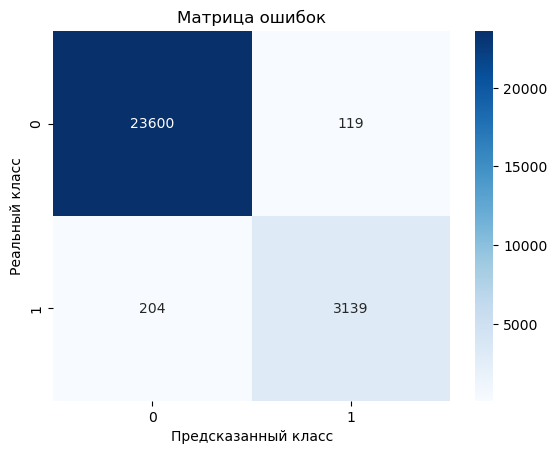

In [335]:
y_pred = (y_pred_proba > best_threshold).astype(int)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Реальный класс')
plt.title('Матрица ошибок')
plt.show()

In [336]:
y_pred_proba1 = cat1.predict_proba(X_test_url)[:,1]
y_pred_proba2 = cat2.predict_proba(X_test_title)[:,1]

In [337]:
y_mean = (y_pred_proba1 + y_pred_proba2)/2

In [338]:
best_threshold = get_best_tresh(y_test,y_mean)

Best Threshold: 0.4469777907030219
Best F1-Score: 0.9731523378582202


In [339]:
y_test_pred1  =cat1.predict_proba(np.vstack(test['vector_url'].values))[:,1]
y_test_pred2  =cat2.predict_proba(np.vstack(test['vector_tittle'].values))[:,1]

In [340]:
pd.DataFrame(((y_test_pred1 + y_test_pred2)/2 >= best_threshold).astype(int),index = test.index,columns=['label']).to_csv('pred.csv')